In [173]:
import pandas as pd
import string
import re
from string import digits
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora
import gensim
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('time_article.csv')

In [15]:
article = df.drop(columns = 'Unnamed: 0')

In [181]:
def preprocessing(x):
    x = x.lower()
#     x = x.replace('—', ' ')
    x = x.replace('-', ' ')
    x = re.sub('\w+@\w+\.[a-z]{3}', ' ', x)
    x = x.translate(str.maketrans(" ", " ", string.punctuation))
    x = x.translate(str.maketrans('', '', digits))
    x = x.replace('“', '')
    x = x.replace('”', '')
    x = x.replace('…', '')
    x = x.replace('’', '')
    x = x.replace('‘', '')  
    x = ' '.join(x.split())
    x = x.split('—')
#     print(x)
    if(x[0].isupper()):
        x = x[1:]
    x = ' '.join(x)
    x = x.strip()
    x = x.replace('  ', '')
    return x
article['cleaned_content'] = article['content'].apply(preprocessing)
# print(article['content'][1])
# article['cleaned_content'][1]

In [196]:
documents = article['cleaned_content'].values.tolist()
lemmatized_text = []

def text_prep(x):
    new = []
    lemmatizer=WordNetLemmatizer()
    #tokenize
    tokens = word_tokenize(x)
    #removing stop words
    result = [i for i in tokens if not i in ENGLISH_STOP_WORDS]
    #lemmatizing
    for i in range(len(result)):
        new.append(lemmatizer.lemmatize(result[i]))
    return new

for document in documents:
    lemmatized_text.append(text_prep(document))


# lemmatized_words[0]
    
# article['cleaned_content'].apply(text_prep)

In [197]:
lemmatized_text

[['united',
  'nation',
  'food',
  'insecurity',
  'north',
  'korea',
  'alarming',
  'level',
  'nearly',
  'half',
  'population',
  'million',
  'people',
  'undernourished',
  'independent',
  'investigator',
  'human',
  'right',
  'country',
  'said',
  'tuesday',
  'tomas',
  'ojea',
  'quintana',
  'told',
  'general',
  'assembly',
  'human',
  'right',
  'committee',
  'child',
  'estimated',
  'suffering',
  'undernutrition',
  'including',
  'face',
  'increased',
  'risk',
  'death',
  'quintana',
  'said',
  'government',
  'primary',
  'responsibility',
  'ensuring',
  'access',
  'food',
  'violating',
  'human',
  'right',
  'obligation',
  'failing',
  'economic',
  'agricultural',
  'policy',
  'addition',
  'said',
  'climate',
  'condition',
  'infertile',
  'land',
  'natural',
  'disaster',
  'negative',
  'impact',
  'sanction',
  'contributed',
  'food',
  'insecurity',
  'broadly',
  'quintana',
  'said',
  'seen',
  'improvement',
  'north',
  'korea',
  'h

In [154]:
# Create Dictionary
id2word = corpora.Dictionary(lemmatized_text)

# Create Corpus
texts = lemmatized_text

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [158]:
#creating LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.027*"country" + 0.018*"india" + 0.016*"world" + 0.013*"year" + '
  '0.011*"people" + 0.011*"health" + 0.010*"indian" + 0.010*"level" + '
  '0.009*"muslim" + 0.009*"resolve"'),
 (1,
  '0.038*"said" + 0.013*"police" + 0.012*"medium" + 0.011*"told" + '
  '0.011*"statement" + 0.010*"according" + 0.008*"later" + 0.008*"german" + '
  '0.007*"case" + 0.007*"law"'),
 (2,
  '0.046*"name" + 0.021*"patriotic" + 0.007*"sharply" + 0.006*"debt" + '
  '0.005*"applause" + 0.004*"scooter" + 0.001*"lebanese" + 0.001*"flashing" + '
  '0.000*"moon" + 0.000*"aya"'),
 (3,
  '0.058*"hong" + 0.046*"kong" + 0.043*"protester" + 0.034*"protest" + '
  '0.021*"city" + 0.021*"police" + 0.017*"mainland" + 0.017*"demonstration" + '
  '0.015*"china" + 0.014*"chinese"'),
 (4,
  '0.019*"country" + 0.018*"government" + 0.017*"party" + 0.016*"election" + '
  '0.015*"minister" + 0.012*"right" + 0.010*"political" + 0.010*"prime" + '
  '0.010*"power" + 0.009*"leader"'),
 (5,
  '0.025*"people" + 0.023*"according" + 

In [156]:
topics = list(lda_model.print_topics())

In [162]:
lda_model.log_perplexity(corpus)
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=lemmatized_text, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4726790185270559


In [170]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
#         model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(lda_model)
        coherencemodel = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

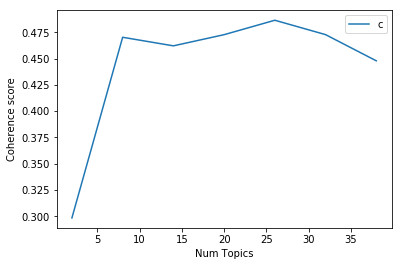

In [175]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=lemmatized_text, start=2, limit=40, step=6)
# Show graph

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show();